<a href="https://colab.research.google.com/github/ElemelonWind/knowledge-graph/blob/main/KG_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Generating KG

## Import Dependencies + Datasets

In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
candidate_sentences = pd.read_csv('https://raw.githubusercontent.com/phgunawan/Latihan-ML/master/wiki_sentences_v2.csv')
candidate_sentences.shape

(4318, 1)

In [ ]:
candidate_sentences['sentence'].sample(5)


1822                  cm  x 8 cm ; the mask itself measures 16 cm x 14 cm .in 2017,
2126                                                  it is written by david brind.
1628                 the film also did well internationally, earning ₹10.37 crore .
1307    scenes were also filmed in mansfield, as well as neighboring ashland, ohio.
3263                                                        it was built in 1693—it
Name: sentence, dtype: object

## Sentence Segmentation & Extraction

In [ ]:
doc = nlp(candidate_sentences["sentence"][2])

for tok in doc:
  print(tok.text, "...", tok.dep_)

christian ... nsubjpass
is ... auxpass
then ... advmod
paralyzed ... ROOT
by ... agent
an ... det
elder ... pobj
. ... punct


In [ ]:
def get_entities(sent):
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""
  prv_tok_text = "" 

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    if tok.dep_ != "punct":
      
      # text associated with subject/object
      if tok.dep_ == "compound":
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " " + tok.text
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " " + tok.text
      
      # subject = first entity
      if tok.dep_.find("subj") == True:
        ent1 = modifier + " " + prefix + " " + tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""
      # object = second entity
      if tok.dep_.find("obj") == True:
        ent2 = modifier + " " + prefix + " " + tok.text

      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text 
    
  return [ent1.strip(), ent2.strip()]

In [ ]:
get_entities(candidate_sentences["sentence"][2])

['christian', 'then  elder']

In [ ]:
entity_pairs = [] 

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:43<00:00, 98.38it/s] 


In [ ]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'existing music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'selene gallio'],
 ['singer', 'sequel']]

In [ ]:
# spaCy's rule-based matching
def get_relation(sent):
  doc = nlp(sent)
  matcher = Matcher(nlp.vocab)
  pattern = [{'DEP': 'ROOT'},
             {'DEP': 'prep', 'OP': '?'},
             {'DEP': 'agent', 'OP': '?'},
             {'POS': 'ADJ', 'OP': '?'}]

  matcher.add("matching_1", [pattern], on_match = None)
  matches = matcher(doc)
  k = len(matches) - 1
  try:
    span = doc[matches[k][1]:matches[k][2]]
  except:
    return "n/a"
  return span.text

In [ ]:
get_relation(candidate_sentences["sentence"][2])

'paralyzed by'

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:38<00:00, 111.29it/s]


In [ ]:
pd.Series(relations).value_counts()[:50]

is               364
was              299
released on       88
include           72
are               70
were              65
released          41
's                37
composed by       32
became            31
have              31
has               30
become            28
released in       27
included          23
called            21
produced          21
had               20
made              20
been              20
considered        20
be                18
used              18
scheduled         17
directed by       16
stars             16
received          15
wrote             14
hired             14
produced by       14
written by        13
introduced in     13
went              13
wanted            12
won               11
began             11
set               11
began in          11
includes          10
gave              10
directed          10
sold              10
gives              9
shot in            9
opened             9
cast as            9
known as           9
features     

## Build KG

In [ ]:
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations, 'sentence': candidate_sentences['sentence']})

kg_df


,source,target,edge,sentence
0,connie,own,decides,"confused and frustrated, connie decides to leave on her own."
1,woman scream,distance,heard in,"later, a woman’s scream is heard in the distance."
2,christian,then elder,paralyzed by,christian is then paralyzed by an elder.
3,temple,fire,set on,the temple is set on fire.
4,,outside cult him,wails with,"outside, the cult wails with him."
...,...,...,...,...
4313,confidencial,barren drama,responded,"confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent."
4314,le parisien,five star rating,gave,and le parisien gave the film their highest five-star rating.
4315,museum collection,"37,000 film titles",includes,"the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs and 20,000 books."
4316,predecessor,historical film 1946,was,"its predecessor was the dutch historical film archive, founded in 1946."


In [ ]:
# drop false negatives
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != 'n/a']

0.056276053728578024

In [ ]:
G = nx.from_pandas_edgelist(kg_df, 'source', 'target', edge_attr=True, create_using=nx.MultiDiGraph())

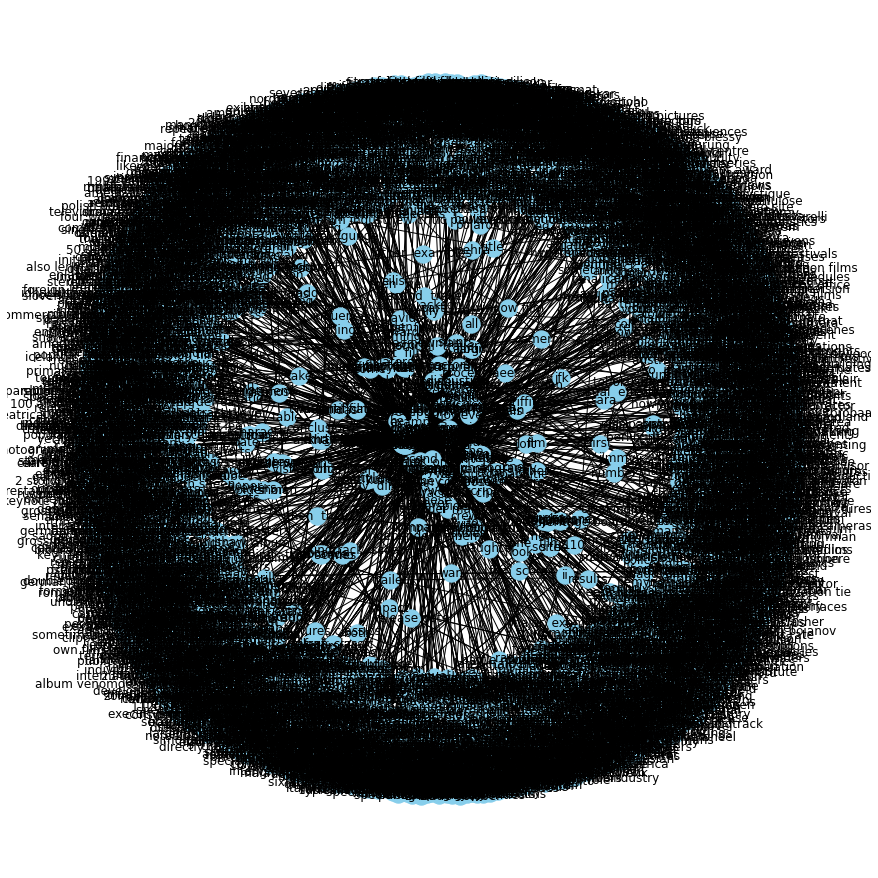

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

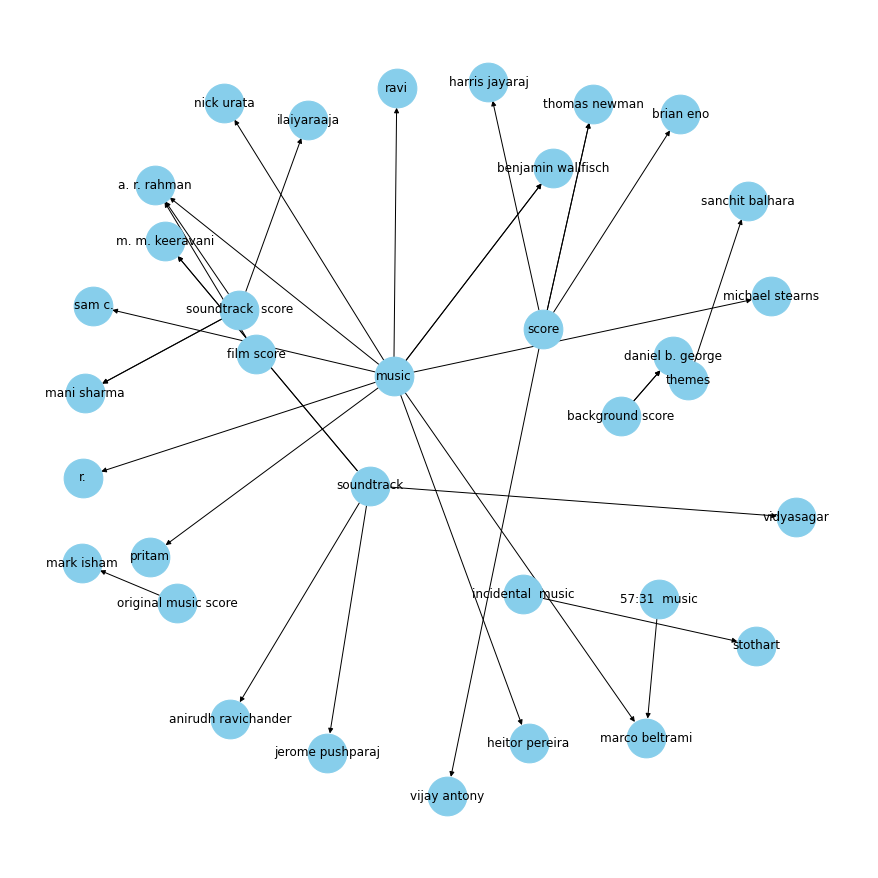

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=='composed by'], 'source', 'target', edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5) # k is distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

## Accuracy

In [ ]:
false_neg = 1 - (kg_df.shape[0] / candidate_sentences.shape[0])
false_neg

0.056276053728578024